### Dependencies used

In [1]:
import sys

sys.path.append("/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection/py")

from functions import *

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast

from PIL import Image,ImageDraw

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50, ResNet50_Weights


from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Using a Neural Network to detect aircraft in satellite images of an airport

A neural network is an machine learning process that trains a computer to interpret data similar to how a human brain would and typically consists of of 1 input layer, n hidden layers and 1 output layer, which the data is ran through and the patterns are studied to teach the computer to recognise these features/patterns in other unseen data.

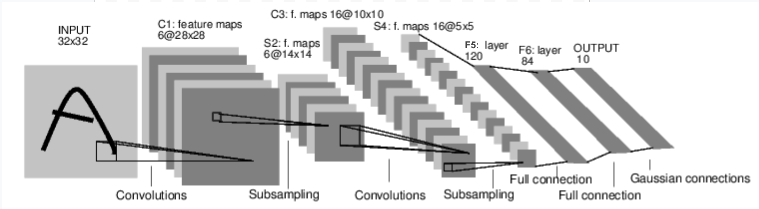

In our case, we will be using a Convolutional Neural Network (CNN), a subset of neural networks that are optimised for object detection/classification. The objective here is to write a CNN using PyTorch, and train it to detect aircraft in satellite images of an airport, information about the airplanes in the images has been provided via an annotations spreadsheet which contain bounding boxes for regions of interest, class of airplane and id for each respective image. This can be extracted and used to compare with the results produced by the neural network.

In [3]:
HOME = "/Users/louie/Documents/Visual Studio Code/ACT Work/Airbus-Aircraft-Detection"
directory_path = os.path.join(HOME, 'airbus-aircrafts-sample-dataset')
image_path = os.path.join(directory_path, 'images')
annotations_path = os.path.join(directory_path, 'annotations.csv')
annotations = pd.read_csv(annotations_path)
annotations.head()

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane


In [4]:
directory_path = os.path.join(HOME, 'airbus-aircrafts-sample-dataset')
image_path = os.path.join(directory_path, 'images')
annotations_path = os.path.join(directory_path, 'annotations.csv')
annotations = pd.read_csv(annotations_path)
annotations.head()

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane


At the moment, the bounding boxes are saved as a set of four coordinaties that compose a square in which an aircraft lies, to use them in visualisation software and our neural network, we'll convert them to length dimensions of a square.

In [5]:
df = pd.read_csv(annotations_path, converters={'geometry': f, 'class': lambda o: 'Aircraft'})

# Create bounds, width and height
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)
df.loc[:,'w'] = df.loc[:,'bounds'].apply(getWidth)
df.loc[:,'h'] = df.loc[:,'bounds'].apply(getHeight)
df.loc[:,'x'] = df.loc[:,'bounds'].apply(getX)
df.loc[:,'y'] = df.loc[:,'bounds'].apply(getY)
df.head(10)

,id,image_id,geometry,class,bounds,w,h,x,y
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Aircraft,"(135, 522, 245, 600)",110,78,135,522
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Aircraft,"(1025, 284, 1125, 384)",100,100,1025,284
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Aircraft,"(1058, 1503, 1130, 1568)",72,65,1058,1503
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Aircraft,"(813, 1518, 885, 1604)",72,86,813,1518
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Aircraft,"(594, 938, 657, 1012)",63,74,594,938
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Aircraft,"(451, 725, 524, 798)",73,73,451,725
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Aircraft,"(1543, 1437, 1614, 1497)",71,60,1543,1437
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Aircraft,"(1485, 1370, 1561, 1437)",76,67,1485,1370
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Aircraft,"(1968, 1624, 2053, 1687)",85,63,1968,1624
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Aircraft,"(1659, 1674, 1733, 1746)",74,72,1659,1674


Now we have the bounding boxes in the proper format,they need to be converted into a form that PyTorch can interpret, this will be done using `torch.utils.data` to create a custom class that stores the image ids and the image directory and the bounding box coordinates in the correct format. Once the images have been located, the image data is converted to a tensor and returned with its corresponding label in a tuple.

In [6]:
class AircraftDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        # Initializes the custom Dataset to store the unique image IDs, DataFrame, image directory, and optionally any image transformations.
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms  # Optional data augmentation or preprocessing, currently set to None.

    def __len__(self) -> int:
        # returns the number of unique images in the dataset
        return self.image_ids.shape[0]

    def __getitem__(self, idx: int):
        # Loads the image at the given index, converts it to a tensor, reads any annotations and labels
        # and returns them as a tuple

        # Get the image ID for the given index.
        image_id = self.image_ids[idx]

        # Filter the DataFrame for records corresponding to this image ID.
        records = self.df[self.df['image_id'] == image_id]

        # Load the image from the image directory using OpenCV.
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)

        # Convert the image from BGR to RGB and normalize pixel values to [0, 1].
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0  # Normalize pixel values to the range [0, 1].

        # Extract bounding box coordinates from the records.
        boxes = records[['x', 'y', 'w', 'h']].values
        # Convert from [x, y, w, h] format to [x_min, y_min, x_max, y_max].
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x_min + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y_min + height

        # Compute the area of each bounding box.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)  # Convert to PyTorch tensor.

        # Assign a label of 1 to all bounding boxes (single-class dataset).
        labels = torch.ones((records.shape[0],), dtype=torch.int64).numpy()

        # Assume that all instances are not part of a crowd (set `iscrowd` to 0).
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        # Create the target dictionary with required metadata.
        target = {
            'boxes': boxes,  # Bounding boxes.
            'labels': labels,  # Object labels.
            'image_id': torch.tensor([idx]),  # Image index as tensor.
            'area': area,  # Area of each bounding box.
            'iscrowd': iscrowd  # Crowd annotations.
        }

        # If transformations are specified, apply them to the image and bounding boxes.
        if self.transforms:
            # Prepare a sample dictionary for the transformations.
            sample = {
                'image': image,  # Input image.
                'bboxes': target['boxes'],  # Bounding boxes.
                'labels': labels  # Labels for the bounding boxes.
            }
            # Apply transformations.
            sample = self.transforms(**sample)
            # Update the image and bounding boxes after transformation.
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        # Return the processed image, target dictionary, and image ID.
        return image, target, image_id

### Defining the model

PyTorch has all the resources necessary to write your own model, however it is usually better to use a pretrained one designed for your task as the weights and parameters will be optimised for its designed task already, in this case is object detection and have already trained on a large dataset. The model I've opted for is [Faster RCNN](https://arxiv.org/abs/1506.01497) with a ResNet-50-FPN backbone.



In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn('DEFAULT')

C:\Users\louie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
num_classes = 2  # 2 total class: aircraft and background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Spliting the dataset into training and validation sets

Neural networks require both a training dataset for pattern recognition and a
test dataset to verify the learnt patterns are correct, this means splitting our dataset appropiately. An 80/20 training/test split is usually used as a rule of thumb for neural networks as large datasets are typically required for effective pattern recognition, but these patterns still need to be evaulated using accurate data.

Using a smaller split such as a 50/50 split can result in underfitting leading to insuffcient representation of the data distribution, especially in complex neural networks. Using a larger split such as a 90/10 split can result in overfitting which leads to unreliable evaluation metrics due to the test set misrepresenting the full distribution, however this is sometimes required on small datasets.

Taking into account the following factors, we will use a 90/10 split due to the size of the dataset being only 103 images.

In [9]:
unique_img = df.image_id.unique() # Get uniqusednge
train_inds, test_inds = train_test_split(range(unique_img.shape[0]), test_size= 0.1) # 90% train, 10% test

train_df = df.iloc[train_inds] # Get training data
test_df = df.iloc[test_inds] # Get test data

In [10]:
# Functions to convert the datasets into tensors and apply and transformations you may want
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [11]:
def collate_fn(batch): # Function to collate data samples into a batch
    return tuple(zip(*batch))

train_dataset = AircraftDataset(train_df, image_path, get_train_transform())
test_dataset = AircraftDataset(test_df, image_path, get_test_transform())

In [12]:
# split the dataset randomly into a train set and a test set removing any potential bias
indices = torch.randperm(len(train_dataset)).tolist()

In [13]:
# define training and validation data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size=16, # how many samples per batch to load
    shuffle=True, # disabling shuffling of the data, setting to True will randomize the data for each epoch, which prevents overfitting to the order of the data
                   # setting to False ensures a deterministic order of the data, which is good for valiadation and testing runs
    collate_fn=collate_fn # calling collate function
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

### Choosing either GPU or CPU or neural network computation



Neural networks are compatible with both GPUs and CPUs, however when avaliable, GPUs are usually significantly better at handling neural networks due to them being composed of thousands of cores designed to handle smaller operations, which allows for much parallel processing and thus faster training times.

In [14]:
# moves model to GPU if avaliable, otherwise CPU is used
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [15]:
# converts the data loader to an iterator which allows for manual stepping through the batches
images, targets, image_ids = next(iter(train_data_loader))

# moves images and targets to GPU if avaliable to use
images = [image.to(device) for image in images]
targets = [{k: v.to(device) if torch.is_tensor(v) else torch.from_numpy(v).to(device) for k, v in t.items()} for t in targets]

In [16]:
# moves the tensor to the CPU as numpy operations are incompatible with GPU tensors
# converts the tensor to a numpy array and sets the data type to int32 to allow for use with downstream functions or visualization tools
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Now that the bounding boxes have been converted to a tensor, we can display a sample of the bounding boxes using OpenCV to draw a rectangle using the bounding boxes dimensions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..220.0].


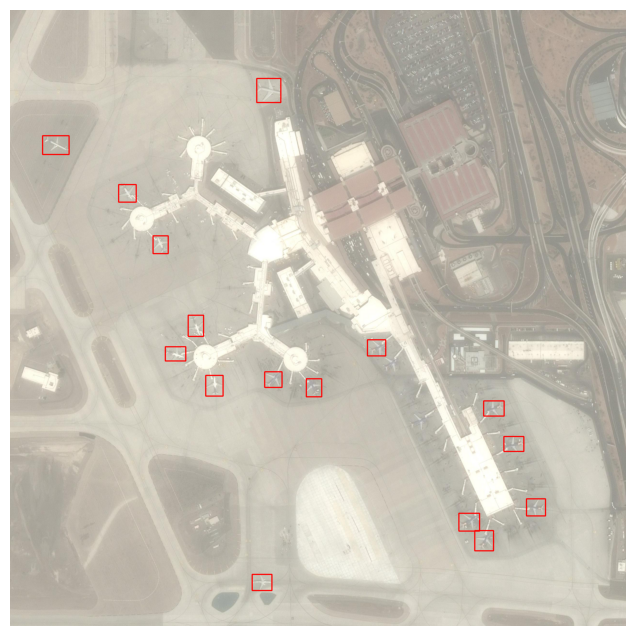

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

### Deciding on the parameters for the CNN
In order for our CNN to learn from the dataset, it needs to backpropogate after each iteration in order to adjust its learning rate. There are two types of variables that determine the models structure and training methods, parameters are the variable defined by the model and are adjusted by the model after each epoch to improve model perfomance and hyperparameters are variables defined by the user before the training begins to give the network a good starting point.

- **Epochs:** The number of times the CNN will see the entire dataset, using a larger number of epochs will increase the accuracy of the CNN, but it also increases the length of training time. A neural network does not train linearly, so a sufficiently large epoch number will produce diminishing returns and could potentially lead to overfitting.

- **Momentum:** Controls how fast the convergence accelerates by adding a fraction of the previous gradient determined by the model, using a large momentum allow for a faster momentum build up and can smooth out oscillations in in the learning processs, but can lead to instability if too large a value is used.

- **Learning Rate(lr):** Controls how model changes its parameters by in response to the estimated error after each epoch, determining the size of the steps taken to minimize the loss function. Learning rate can be static in size, or dynamic in it adjust itself based upon the loss each epoch. Using a low learning rate results in longer training times and more accurate results, while using a larger learning rate is faster, but can lead to overshooting.

- **Batch size:** How many data pieces are sent to the neural network at once before the model updates its parameters. Using a smaller batch size (eg 4, 8, 16) produces a model that is more capable of handling datasets with lots of variance and is less taxing on the system, but has a slower training rate, using a larger batch size (eg 32, 64, 128) has a much faster training time and produces a more stable convergence, but is more computationally expensive.


Deciding what parameters and hyperparameters to use can be a difficult task that changes from dataset to dataset, but finding optimal parameters is key to producing a effective model.



In [18]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) #Sets a dynamic learning rate
lr_scheduler = None #Sets a static learning rate

num_epochs = 20 # number of times the model will be trained on the entire dataset

### Training the neural network
Now that we've decided on our parameters, hyperparameters and number of epochs, our CNN is ready to be trained on the dataset, a typical training process of a neural network consists of:
- Taking an input through the input layer, in our case, a set of images
- Iterating over the dataset
- Processing the input through the hidden layers of the network
- Computing how accurate the output is and take an average of the loss
- Backpropogating through gradients and update weights to adjust hidden layers
- Repeating these steps for a specified number of epochs

In [19]:
# Create lists to store loss values for training and validation
train_loss_values = []
train_acc = []

train_loss_hist = Averager()

for epoch in range(num_epochs):
    # Reset the training loss history
    train_loss_hist.reset()

    # Training Loop
    model.train()  # Set the model to training mode
    for images, targets, image_ids in train_data_loader:  # iterate over the training data loader
        # Move image tensors and annotations to the specified device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if torch.is_tensor(v) else torch.from_numpy(v).to(device) for k, v in t.items()} for t in targets]

        train_loss_dict = model(images, targets)  # Passes images and targets to the model and returns a loss dictionary

        train_losses = sum(train_loss for train_loss in train_loss_dict.values())  # Computes the sum of all losses
        train_loss_value = train_losses.item()  # Converts the loss value to a Python scalar

        train_loss_hist.send(train_loss_value)  # Sends the loss value to the loss history object
        train_loss_values.append(train_loss_value)  # Append the current loss value to the list for plotting

        optimizer.zero_grad()  # Clear gradients
        train_losses.backward()  # Backpropagation
        optimizer.step()  # Update model parameter

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss_hist.value:.4f}") # Print the average loss for the epoch

Epoch [1/20] - Train Loss: 3.3748
Epoch [2/20] - Train Loss: 1.3397
Epoch [3/20] - Train Loss: 1.2984
Epoch [4/20] - Train Loss: 1.2859
Epoch [5/20] - Train Loss: 1.2353
Epoch [6/20] - Train Loss: 1.1866
Epoch [7/20] - Train Loss: 1.2000
Epoch [8/20] - Train Loss: 1.1238
Epoch [9/20] - Train Loss: 1.1001
Epoch [10/20] - Train Loss: 1.0129
Epoch [11/20] - Train Loss: 0.9437
Epoch [12/20] - Train Loss: 0.8697
Epoch [13/20] - Train Loss: 0.8725
Epoch [14/20] - Train Loss: 0.8280
Epoch [15/20] - Train Loss: 0.7916
Epoch [16/20] - Train Loss: 0.7554
Epoch [17/20] - Train Loss: 0.6754
Epoch [18/20] - Train Loss: 0.6696
Epoch [19/20] - Train Loss: 0.6181
Epoch [20/20] - Train Loss: 0.6013


### Interepting the results

The loss curve displays how accurate the model is at the end of each epoch, with the right parameters chosen for the model, the loss should decrease with each epoch and tend towards 0. If the loss curve doesn't display these traits, there could be an issue with the data/parameters.

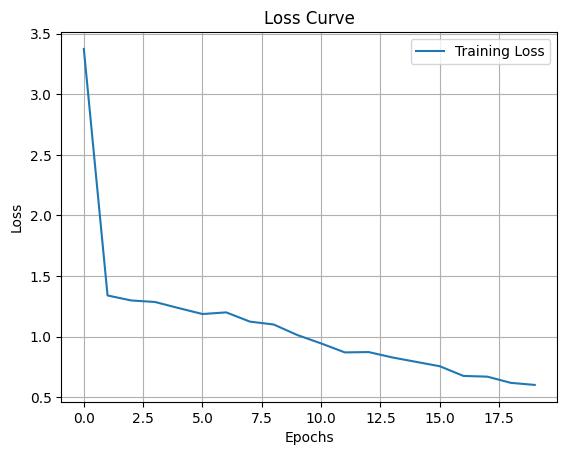

In [20]:
# Plot the loss curve
plt.figure()
plt.plot(train_loss_values, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

The loss curve for this dataset steadily decreases in the early epochs, however it begins to fluctuate around a loss value of 1 in the later epochs, this can be caused by insufficient shuffling and/or small datasets resulting in overfitting of the model.

### Model Evaluation
Confidence scores are values calculated by the neural network to show how certain the model is in its prediction of the detected feature and range from 0 to 1. Using this calculated confidence score, we can draw bounding onto the data where the model is confident an airplane is located.

In [21]:
model.eval() # in evaluation mode, dropout layers are disabeled, mean and variance statistics aren't updated
images, targets, image_ids = iter(test_data_loader).__next__() # converts the PyTorch data loader to an iterator and retrieves the next batch of data
data=iter(test_data_loader).__next__()

In [22]:
output=model([images[1].to(device)]) # passes an image from the batch to the model and returns the the predicted bounding boxes, class labels and confidence scores

In [23]:
# extracts the predicted bounding boxes and confidence scores
out_box=output[0]['boxes']
out_scores=output[0]['scores']
len(out_box)

65

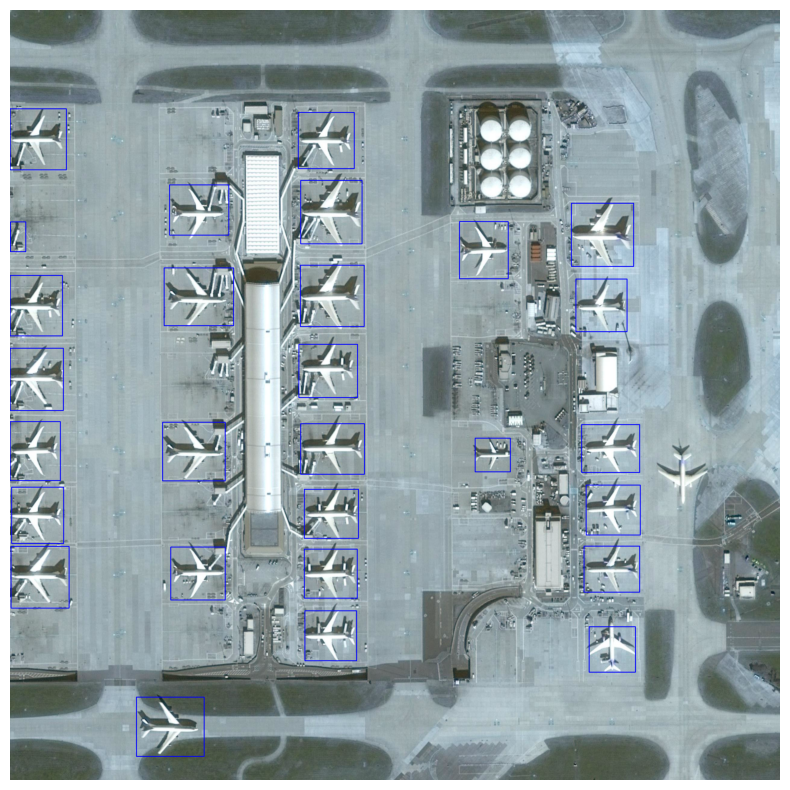

In [24]:
im=(images[1].permute(1,2,0).cpu().detach().numpy()*255).astype('uint8') #

for i in range(len(out_box)):
    if out_scores[i] >= 0.9:
        # Draw the rectangle on the image
        box = list(map(int, out_box[i]))  # Convert box coordinates to integers
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)  # Blue rectangle

# Convert the image from BGR to RGB for displaying with matplotlib
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

Our neural network successfully detected almost all the aircraft in the image with a 90% confidence score, however it also incorrectly identified a couple of features in the image as airplanes within this confidence range. The accuracy of the model can be improved by tuning the hyperparameter further and training with more epochs.

### Saving the model
The models training parameters and hyperparameters can be saved using `torch.save` to be used again for future models

In [25]:
model_path = os.path.join(HOME, 'py/Question 2/fasterrcnn_resnet50_fpn.pth')
torch.save(model.state_dict(), model_path)  # saves the trained model for future use

### Neural Network vs classical Technique

Neural networks offer high accuracy, adaptability and robustness that can handle complex scenarios such as obscured/truncated features and lighting changes and are good for advanced tasks that require large scalability for large datasets. However they can be very computationally expensive and energy costly to train and run, require large labelled datasets to train off which can be expensive to obtain and are prone to overfitting without proper tuning.

Classical methods such as ORB are usually much more efficient than neural networks, offering significantly faster computations and require much less resources to compute, and do not require training data to operate. However they struggle with possible variations that could arise in the data such as noise or obscured/truncated features, are fixed on rigid characteristics to locate features and usually are less precise than a properly trained neural network.

Based upon these characteristics, each methods has its own stregnths and limitations that make them suitable for different situations, neural networks are more suited for advanced tasks that require flexibility in its approach, classical methods are more suited to real-time applications where fast speeds and small resource consumption are required.